In [10]:
import os
from datetime import datetime
import backtrader as bt

os.chdir('/Volumes/Data/Chipy/Py-Finance/Crypto/TechnicalAnalysis/')

In [23]:
class BuyandHold(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
 
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def next(self):
        if not self.position:
            self.order = self.buy()

Starting Portfolio Value: 10000.00
Final Portfolio Value: 257545.50
Final Cash Value: 65.96
Total Value: 257611.46


<IPython.core.display.Javascript object>


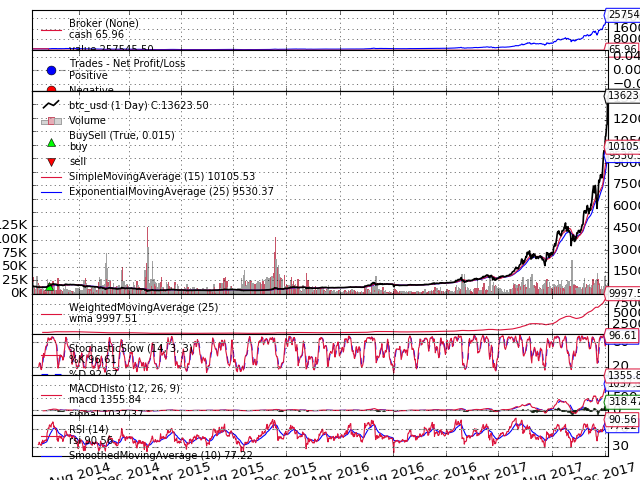

[[<matplotlib.figure.Figure at 0x12745f278>]]

In [25]:
cerebro = bt.Cerebro()

#data = bt.feeds.YahooFinanceData(dataname='YHOO', fromdate=datetime(2011, 1, 1),todate=datetime(2012, 12, 31))
#data = bt.feeds.PandasData(dataname=dataframe)
data = bt.feeds.GenericCSVData(dataname='btc_usd.csv',dtformat='%Y-%m-%d',openinterest=-1)

cerebro.adddata(data)
cerebro.addstrategy(BuyandHold)
cerebro.addsizer(bt.sizers.PercentSizer,percents=100)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Final Cash Value: %.2f' % cerebro.broker.getcash())
print('Total Value: %.2f' % (cerebro.broker.getvalue()+cerebro.broker.getcash()))
cerebro.plot()